In [56]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import html
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

In [57]:
pd.set_option('display.max_row', 10)
df = pd.read_csv('../website_classification.csv')
df.tail(10)

,website_url,cleaned_website_text,Category
987,http://6h5bzxeinwl326ihn7lfy2rwa2xvfkkpacosokz...,loliporn loliporn main buy gallery video tags ...,Adult
988,http://2qnn6dvxekhgjxzo5p5qu76rkvks67k3p7yptnl...,loliporn loliporn main buy gallery video tags ...,Adult
989,http://search7tdrcvri22rieiwgi5g46qnwsesvnubqa...,xplay deep search results search results offic...,Adult
990,http://search7tdrcvri22rieiwgi5g46qnwsesvnubqa...,teen deep search results search results offici...,Adult
991,http://dest6wpcn2hqnzuwcukq4vsuyl2k33btshrvj7p...,destroyed daughters private extreme teen porn ...,Adult
992,http://qsfvxmx5b2qjcwlazipbnmkkm7nbar4qjgb7ltl...,wanna fuck me teen girls teen sex teen rape yo...,Adult
993,http://36deeqadwptajwumq7375px4osde5yupz7flhc7...,teen boy cp free video the golden club forum o...,Adult
994,http://v5pjd77uzlm72vyh7ial5ih6sa7j5ndvhhlpnld...,child teen sex ls magazine onion big onions pe...,Adult
995,http://amateddr6lvn3z3vmdrnurhyznbwavz62yubj27...,amateur teen porn amateur teen porn home categ...,Adult
996,http://kindeana3njoc4huumj2kpxd7dkewjtemtfi6si...,kindergarten darknet teen sex kindergarten dar...,Adult


In [62]:
df['Category'].value_counts()

Computers and Technology           299
Marketplace                        119
Social Networking and Messaging    113
News                                94
Narcotics                           90
Adult                               88
Law and Government                  83
Financial Crime                     60
Intelligence                        33
Forums                              16
Name: Category, dtype: int64

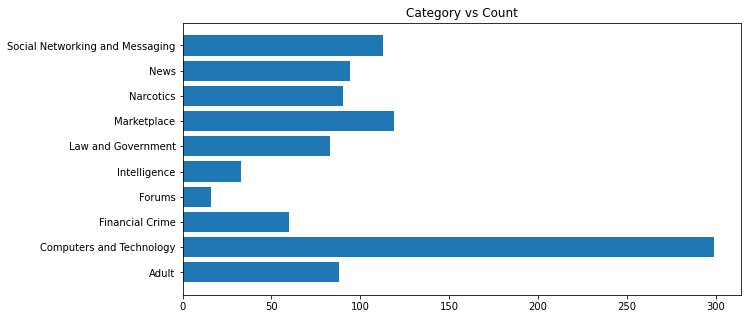

In [63]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [7]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [8]:
stop_words = []
stop_words.extend(["decemeber","dec","january","jan","feb","february","march","mar","may","april","apr","june","jun","july","jul","august","aug","september","sept","oct","october","nov","november",
                   "one","two","three","hundred","thousand","million","billion","today","tomorow","week","month","year","sign in","login","sign up"])

stop_words.extend(['afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'antigua', 'argentina', 'armenia', 'australia',
    'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize',
    'benin', 'bhutan', 'bolivia', 'bosnia', 'botswana', 'brazil', 'brunei', 'bulgaria', 'burkina', 'burundi',
    'cambodia', 'cameroon', 'canada', 'cape', 'central', 'chad', 'chile', 'china', 'colombia', 'comoros',
    'congo', 'costa', 'croatia', 'cuba', 'cyprus', 'czech', 'denmark', 'djibouti', 'dominica', 'dominican',
    'east', 'ecuador', 'egypt', 'el', 'equatorial', 'eritrea', 'estonia', 'ethiopia', 'fiji', 'finland',
    'france', 'gabon', 'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea',
    'guyana', 'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland',
    'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'kiribati', 'korea', 'kosovo',
    'kuwait', 'kyrgyzstan', 'laos', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein',
    'lithuania', 'luxembourg', 'macedonia', 'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta',
    'marshall', 'mauritania', 'mauritius', 'mexico', 'micronesia', 'moldova', 'monaco', 'mongolia', 'montenegro',
    'morocco', 'mozambique', 'myanmar', 'namibia', 'nauru', 'nepal', 'netherlands', 'new', 'nicaragua',
    'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'panama', 'papua', 'paraguay', 'peru',
    'philippines', 'poland', 'portugal', 'qatar', 'romania', 'russia', 'rwanda', 'samoa', 'san', 'sao',
    'senegal', 'serbia', 'seychelles', 'sierra', 'singapore', 'slovakia', 'slovenia', 'solomon', 'somalia',
    'south', 'spain', 'sri', 'st.', 'sudan', 'suriname', 'swaziland', 'sweden', 'switzerland', 'syria',
    'taiwan', 'tajikistan', 'tanzania', 'thailand', 'timor-leste', 'togo', 'tonga', 'trinidad', 'tunisia',
    'turkey', 'turkmenistan', 'tuvalu', 'uganda', 'ukraine', 'united', 'uruguay', 'uzbekistan', 'vanuatu',
    'vatican', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe'])

stop_words.extend([
    'dollar', 'euro', 'pound', 'rupee', 'yen', 'yuan', 'won', 'franc', 'dinar', 'peso', 'lira', 'rupee', 'ruble',
    'koruna', 'baht', 'real', 'zloty', 'rand', 'shekel', 'krona', 'dirham', 'forint', 'colón', 'hryvnia',
    'leu', 'ringgit', 'kuna', 'lempira', 'cordoba', 'kwacha', 'taka', 'quetzal', 'birr', 'rial', 'tenge',
    'shilling', 'kwacha', 'naira', 'rial', 'dinar', 'rupiah', 'pula', 'riyal', 'dinar', 'lilangeni', 'krona',
    'franc', 'syli', 'peso', 'shilling', 'baht', 'vatu', 'bolivar', 'dong', 'rial'
])

In [9]:
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'_+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [token for token in tokens if not token.isdigit()]
    cleaned_text = ' '.join(tokens)
    tokens = cleaned_text.split()
    tokens = [token for token in tokens if token not in stop_words]
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [10]:
from darkwebScrapper import Scraper
def content_generation(website,dark_web):
    try:
        # scrapTool = ScrapTool()
        # web = scrapTool.visit_url(website)
        # text = cleaning_text(web['website_text'])
        web = Scraper(website,dark_web)
        text = cleaning_text(web)
        return text
    except Exception as e:
        print('Error: ',website)
        print(e)
        return None

In [29]:
websites = [
    ('http://young-girls-fucked-free-video.wzpk766pahw6qgtrv7jhn7yjtztpx35mhafmf7zobaauynvem7lfrgad.onion/49.html',True,"Adult",'Teen/Kids'),
    ('http://uw6wxgibykcokqpyyqfmdijkwaukkxcey3sb6bnhvy2mq4cbjpwfsrid.onion/items/fraud/xxx-logins?page=5',True,'Adult','Non-Teen'),
    ('http://4g2q6mg6snimrruya2wbxlaybbj74n7eidg26k3vbhpwm6uxezqrdrqd.onion/u/enjoymyaccounts?page=7',True,'Adult','Non-Teen'),
    ('http://lp2fkbyfmiefvscyawqvssyh7rnwfjsifdhebp5me5xizte3s47yusqd.onion/index.php/78/i-m-a-virgin-tell-us-about-your-first-sex?show=267',True,'Adult','Non-Teen'),
    ('http://exchayfmcj2qk6njyrs4dxutzrreyafky67zhs6h27m7pppz7hk2dmad.onion/content/86544t32gff2d3eg241gh1gh1.php',True,'Adult','Teen/Kids'),
    ('http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/Security/oe47bfcf408ed831cc/1.oe',True,'Adult','Teen/Kids'),
    ('http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/General/oe2851ae828f7a8a95/1.oe',True,'Adult','Teen/Kids'),
    ('http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/General/oeb33dcf67b2d1a56f/1.oe',True,'Adult','Teen/Kids'),
    ('http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/Accessibility/oe2b6a0b10b0b418a8/1.oe',True,'Adult','Teen/Kids'),
    ('http://rduidi3frecb3bgme3glcz73weh2legrwnv54cjmsmb23lmli54zrmqd.onion/item/9r3ixibcpl',True,'Adult','Non-Teen'),
    ('http://underdiriled6lvdfgiw4e5urfofuslnz7ewictzf76h4qb73fxbsxad.onion/category/ADULT',True,'Adult','Non-Teen'),
    ('http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/41.html',True,'Adult','Teen/Kids'),
    ('http://snuul35t67fz5gyuv5ah6uzcc2djc56hac767zc7ppxgltgz3dhbn2id.onion/post/6jntr13zngo2dzbsqsjk',True,'Adult','Non-Teen'),
    ('http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/21.html',True,'Adult','Teen/Kids'),
    ('http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/48.html',True,'Adult','Teen/Kids'),
    ('http://76m767rbfcuisydxqavoiajrja44fw4ev3qgfqkw7ks65dwuknu6qmyd.onion/?tag=Nude',True,'Adult','Teen/Kids'),
    ('http://onionax33cpuvzskcwcwobcv66qwcyfzo24yeowgjpmpp4mklq7fohid.onion/category.php?text=Adult&page=1',True,'Adult','Teen/Kids'),
    ('http://w63zkhlfkez2clfbiuadklywovwzqe2injh6vxtv2nzsv7eig5hzjvad.onion/',True,'Adult','Teen/Kids'),
    ('http://6h5bzxeinwl326ihn7lfy2rwa2xvfkkpacosokzdkodc7o2fixhtzjid.onion/',True,'Adult','Teen/Kids'),
    ('http://2qnn6dvxekhgjxzo5p5qu76rkvks67k3p7yptnlb7h4dh4srbr4qolyd.onion/',True,'Adult','Teen/Kids'),
    ('http://search7tdrcvri22rieiwgi5g46qnwsesvnubqav2xakhezv4hjzkkad.onion/result.php?search=Xplay',True,'Adult','Non-Teen'),
    ('http://search7tdrcvri22rieiwgi5g46qnwsesvnubqav2xakhezv4hjzkkad.onion/result.php?search=Teen',True,'Adult','Teen/Kids'),
    ('http://dest6wpcn2hqnzuwcukq4vsuyl2k33btshrvj7pueangxeleol2fsqid.onion/',True,'Adult','Teen/Kids'),
    ('http://qsfvxmx5b2qjcwlazipbnmkkm7nbar4qjgb7ltlobcs7a7oo66c2biyd.onion/',True,'Adult','Teen/Kids'),
    ('http://36deeqadwptajwumq7375px4osde5yupz7flhc7fhaklmetmkpouciid.onion/',True,'Adult','Teen/Kids'),
    ("http://v5pjd77uzlm72vyh7ial5ih6sa7j5ndvhhlpnldtkm47x6logct7pzid.onion/",True,'Adult','Teen/Kids'),
    ('http://bk74wqmsbzpo7euuciaea7actwxwfdtxfyi7hryipt5g53ttubbouxad.onion/',True,'Adult','Teen/Kids'),
    ('http://amateddr6lvn3z3vmdrnurhyznbwavz62yubj27gtjnonvox5ywzmoqd.onion/',True,'Adult','Teen/Kids'),
    ('http://kindeana3njoc4huumj2kpxd7dkewjtemtfi6siah5o3b5k4uutluyyd.onion/',True,'Adult','Teen/Kids'),
]

for website in websites:
    try:
        content = content_generation(website[0],website[1])
        # print(content)
        content_list_1 = [website[0],content,website[2]]
        content_list_adult = [website[0],content,website[3]]
        df.loc[len(df)] = content_list_1
        adult.loc[len(adult)] = content_list_adult
    except Exception as e:
        print(website,": ",e)


Getting... http://young-girls-fucked-free-video.wzpk766pahw6qgtrv7jhn7yjtztpx35mhafmf7zobaauynvem7lfrgad.onion/49.html


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://uw6wxgibykcokqpyyqfmdijkwaukkxcey3sb6bnhvy2mq4cbjpwfsrid.onion/items/fraud/xxx-logins?page=5


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://4g2q6mg6snimrruya2wbxlaybbj74n7eidg26k3vbhpwm6uxezqrdrqd.onion/u/enjoymyaccounts?page=7


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://lp2fkbyfmiefvscyawqvssyh7rnwfjsifdhebp5me5xizte3s47yusqd.onion/index.php/78/i-m-a-virgin-tell-us-about-your-first-sex?show=267


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://exchayfmcj2qk6njyrs4dxutzrreyafky67zhs6h27m7pppz7hk2dmad.onion/content/86544t32gff2d3eg241gh1gh1.php


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/Security/oe47bfcf408ed831cc/1.oe


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/General/oe2851ae828f7a8a95/1.oe


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/General/oeb33dcf67b2d1a56f/1.oe


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://eprise7j66huuxbdx654pnk4j3ktps6rekmlxmjndqqad6dbvfr2qxad.onion/Forum/Accessibility/oe2b6a0b10b0b418a8/1.oe


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://rduidi3frecb3bgme3glcz73weh2legrwnv54cjmsmb23lmli54zrmqd.onion/item/9r3ixibcpl


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://underdiriled6lvdfgiw4e5urfofuslnz7ewictzf76h4qb73fxbsxad.onion/category/ADULT


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/41.html


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://snuul35t67fz5gyuv5ah6uzcc2djc56hac767zc7ppxgltgz3dhbn2id.onion/post/6jntr13zngo2dzbsqsjk


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/21.html


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://jwzzevnbrletxx7e4nqmfv73mre7rjik6nktidduppjcei6xr75aybyd.onion/new-boys/48.html


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://76m767rbfcuisydxqavoiajrja44fw4ev3qgfqkw7ks65dwuknu6qmyd.onion/?tag=Nude


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://onionax33cpuvzskcwcwobcv66qwcyfzo24yeowgjpmpp4mklq7fohid.onion/category.php?text=Adult&page=1


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://w63zkhlfkez2clfbiuadklywovwzqe2injh6vxtv2nzsv7eig5hzjvad.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://6h5bzxeinwl326ihn7lfy2rwa2xvfkkpacosokzdkodc7o2fixhtzjid.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://2qnn6dvxekhgjxzo5p5qu76rkvks67k3p7yptnlb7h4dh4srbr4qolyd.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://search7tdrcvri22rieiwgi5g46qnwsesvnubqav2xakhezv4hjzkkad.onion/result.php?search=Xplay


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://search7tdrcvri22rieiwgi5g46qnwsesvnubqav2xakhezv4hjzkkad.onion/result.php?search=Teen


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://dest6wpcn2hqnzuwcukq4vsuyl2k33btshrvj7pueangxeleol2fsqid.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://qsfvxmx5b2qjcwlazipbnmkkm7nbar4qjgb7ltlobcs7a7oo66c2biyd.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://36deeqadwptajwumq7375px4osde5yupz7flhc7fhaklmetmkpouciid.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://v5pjd77uzlm72vyh7ial5ih6sa7j5ndvhhlpnldtkm47x6logct7pzid.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://bk74wqmsbzpo7euuciaea7actwxwfdtxfyi7hryipt5g53ttubbouxad.onion/
Error:  http://bk74wqmsbzpo7euuciaea7actwxwfdtxfyi7hryipt5g53ttubbouxad.onion/
SOCKSHTTPConnectionPool(host='bk74wqmsbzpo7euuciaea7actwxwfdtxfyi7hryipt5g53ttubbouxad.onion', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.contrib.socks.SOCKSConnection object at 0x0000029D7A26A640>: Failed to establish a new connection: 0x01: General SOCKS server failure'))
Getting... http://amateddr6lvn3z3vmdrnurhyznbwavz62yubj27gtjnonvox5ywzmoqd.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult
C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


Getting... http://kindeana3njoc4huumj2kpxd7dkewjtemtfi6siah5o3b5k4uutluyyd.onion/


C:\Users\User01\AppData\Local\Temp/ipykernel_12052/3009004019.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.loc[len(adult)] = content_list_adult


In [64]:
df['Category'].value_counts()

Computers and Technology           299
Marketplace                        119
Social Networking and Messaging    113
News                                94
Narcotics                           90
Adult                               88
Law and Government                  83
Financial Crime                     60
Intelligence                        33
Forums                              16
Name: Category, dtype: int64

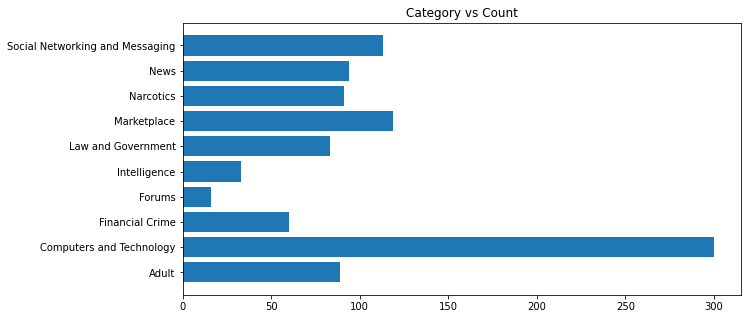

In [31]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [55]:
df.to_csv("website_classification.csv",index=False)
# adult.to_csv("../Hierarchal model/Adult/adult_subcategory_classification.csv",index=False)

#### Mischelleanous Code

In [9]:
df.drop(df.loc[(df["cleaned_website_text"].isnull())]["website_url"].index,inplace=True)

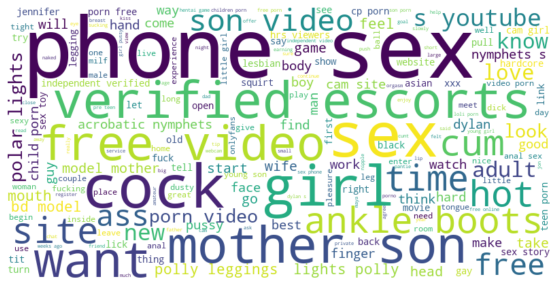

In [13]:
from wordcloud import WordCloud

category_name = "Adult"
category_data = df[df["Category"]==category_name]['cleaned_website_text']
category_text = ' '.join(category_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

important_words = wordcloud.words_.keys()


In [60]:
df.drop([456,907],inplace=True)

In [61]:
df.reset_index(drop=True, inplace=True)

In [13]:
df[df["website_url"].duplicated(keep=False)]

,website_url,cleaned_website_text,Category
